Group 6: Tim Angevare, Pjottr van Zee, Tion Zijlstra, Lilla Mikovics, Pascal Bakker, Cristian Haidău

[GitHub](https://github.com/TimAngevare/AnonMarketWebscraper)

The purpose of this notebook is to scrape a marketplace on the dark web. The chosen marketplace for this is AnonMarket, because it does not have DDoS protection. In this notebook, only the drugs section will be scraped, as this category already has hundreds of posts.

The goal is to visualise the sellers, and types of drugs and their prices using pandas and matplotlib. This gives us an insight in the magnitude of industry and will show us potential entry points for fighting the drug suppliers.

Tor needs to be running in the background to allow a connection to the marketplace.

In [2]:
import requests
from requests.exceptions import ProxyError
from time import sleep
from bs4 import BeautifulSoup

Set up the proxy and see if it works. A tor service was installed on the computer on port 9050. We need to set this up in the code and connect to access the dark web.

If an error about a SOCKS dependency is given, make sure PySocks is installed for Python3.

In [5]:
proxies = {
    'http' : 'socks5h://127.0.0.1:9050',
    'https' : 'socks5h://127.0.0.1:9050'
}
ip = requests.get('https://ident.me').text

spoofedIP = requests.get('https://ident.me',proxies=proxies).text

print('Your ip: ' + ip + '\nYour spoofed ip: ' + spoofedIP)

Your ip: 2a02:a44d:678e:1:9954:5b45:7135:cdeb
Your spoofed ip: 192.42.116.211


Test if Tor is correctly configured.

In [6]:
requests.get('https://check.torproject.org/', proxies=proxies).text.find("Congratulations. This browser is configured to use Tor.") != -1

True

Fetch the homepage of the marketplace AnonMarket.

In [7]:
onion_url = 'http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion'

try:
    browser = requests.session()
    browser.headers = {
        'Accept':    'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Encoding':    'gzip, deflate',
        'Accept-Language':    'en-us,en;q=0.5',
        'User-Agent':         'Mozilla/5.0 (Windows NT 6.1; rv:24.0) Gecko/20100101 Firefox/24.0'
    }
    response = browser.get(onion_url, proxies=proxies, timeout=30, allow_redirects=True)
    while True:
        sleep(1)
        if response.text.find("DDoS") == -1:
            break
        else:
            print(response.history)
    
    # Process the response here
except ProxyError as e:
    print(f"Error: {e}")

Extract the different categories of drugs.

In [8]:
categories_list = []

soup = BeautifulSoup(response.content, 'html.parser')
drug_categories = soup.find_all('div', class_="subcat_1")

for div in drug_categories:
    if div.text.find('View all') == -1:
        category = div.text.strip()
        a_tag = div.parent
        url = onion_url + a_tag['href']
        dic = {"name" : category, "url" : url, "pages" : 0, "posts" : []}
        categories_list.append(dic)

print("Categories:", list(map(lambda x: x['name'], categories_list)))

Categories: ['Benzos', 'Ecstasy', 'Opiods', 'Psychedelics', 'Cannabis', 'Stimulants', 'Dissociatives', 'Steroids', 'Prescription', 'Raw Drugs', 'Rcs China', 'Drugs Precursors', 'Weight Scale', 'Drugs Paraphernalia', 'Physical Drop']


Create a function to scrape the information of each post on the page.

In [9]:
def scrape_page(page, category):
    post_section = page.find('div', class_='items')
    posts = post_section.find_all('div', class_='item')
    for post in posts:
        url = category["url"] + post.contents[1]['href']
        seller = post.find('a', class_='seller').text.strip()
        title = post.find('div', class_='title').text.strip()
        price = post.find('div', class_='price').text.strip().split(' ')[0]
        tbody = post.find('table')
        stars = tbody.find('div', class_='stars2')['style'].split(':')[-1]
        stars = round(float(stars[:-1]))
        post_data = {'title' : title, 'url' : url, 'seller' : seller, 'price' : price, 'stars' : stars}
        category['posts'].append(post_data)

Scrape the categories for info and add the page numbers.

In [ ]:
for category in categories_list: 
    print(category["name"])
    response = browser.get(category["url"], proxies=proxies, timeout=20, allow_redirects=False)
    soup = BeautifulSoup(response.content, 'html.parser')
    category["pages"] = soup.find_all('div', class_='page')[-1].text.strip()
    for i in range(1, int(category["pages"]) + 1):
        try:
            page = browser.get(category["url"] + '/' + str(i) + '/', proxies=proxies, timeout=20, allow_redirects=False)
            page = BeautifulSoup(page.content, 'html.parser')
            scrape_page(page, category)
        except (requests.exceptions.ConnectionError, requests.exceptions.RequestException) as e:
             print("Ran into a connection issue:", e)
             sleep(5)


Export the scraped data to a CSV file.

In [187]:
import pandas as pd

transformed_data = []
for category in categories_list:
    category_name = category['name']
    posts = category['posts']
    for post in posts:
        post_attributes = {
            'category': category_name,
            'title': post['title'],
            'url': post['url'],
            'seller': post['seller'],
            'price': post['price'],
            'rating': post['stars']
        }
        transformed_data.append(post_attributes)

# Create a Pandas DataFrame
df = pd.DataFrame(transformed_data)
df.to_csv("posts.csv")


In [12]:
df = pd.read_csv("posts.csv")

Clean the price value to take out the ',' in 1000.

In [13]:
df['price'] = df['price'].str.replace(',','')
df['price'] = pd.to_numeric(df['price'], errors='coerce')

df['price'].describe()

count    1.391800e+04
mean     8.285492e+03
std      8.478088e+05
min      5.000000e+00
25%      4.745000e+01
50%      1.265750e+02
75%      4.100000e+02
max      1.000000e+08
Name: price, dtype: float64

Get the number of posts and average rating for each seller.

In [15]:
seller_df = df[['seller', 'rating']] \
    .groupby('seller') \
    .agg({'seller' : 'size', 'rating' : 'mean'}) \
    .rename(columns={'seller':'posts'}) \
    .reset_index() \
    .sort_values(by='posts', ascending=False)

print(len(seller_df), "sellers found")
seller_df.head(10)

775 sellers found


,seller,posts,rating
106,cannabiz,242,1.239669
618,sportlife,215,10.400000
488,nextlevel,211,8.308057
129,cindicator,202,1.485149
628,strainpirate,201,48.721393
186,donalddrugs,151,31.721854
135,coffeeshop,143,12.636364
175,digitalsin,135,3.111111
625,steroidwarehouse,130,6.923077
557,pygmalion,118,13.330508


We believe the police should further investigate the top 3 sellers identified above. Taking them down would have the most impact in the drug world as they are responsible for the most volume.

Visualise the top 25 sellers in a bar chart based on the amount of posts.

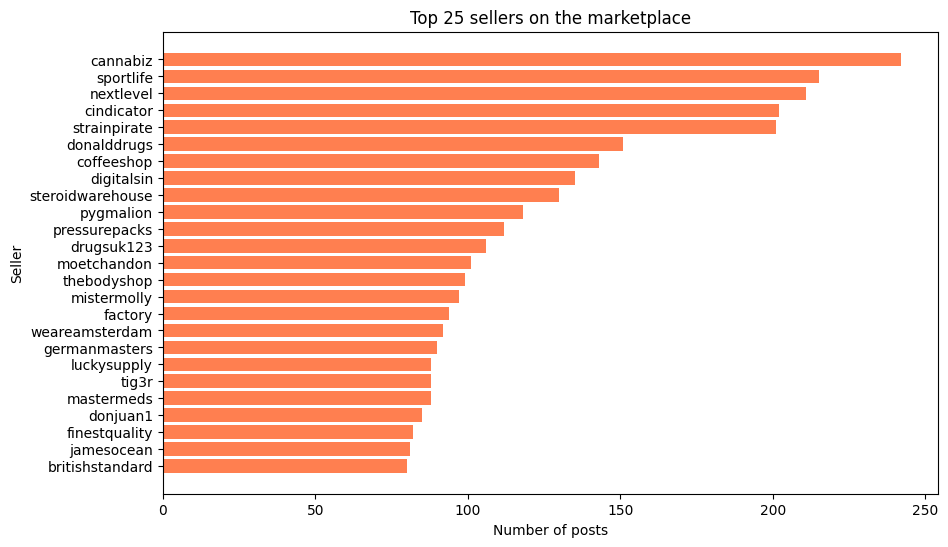

In [16]:
import matplotlib.pyplot as plt

seller_small = seller_df.head(25)
y = list(reversed(list(seller_small['posts'])))
labels = list(reversed(list(seller_small['seller'])))

plt.figure(figsize=(10, 6))
plt.barh(labels, y, color='coral')
plt.title("Top 25 sellers on the marketplace")
plt.xlabel("Number of posts")
plt.ylabel("Seller")
plt.show()

Create a boxplot of the drug prices per category.

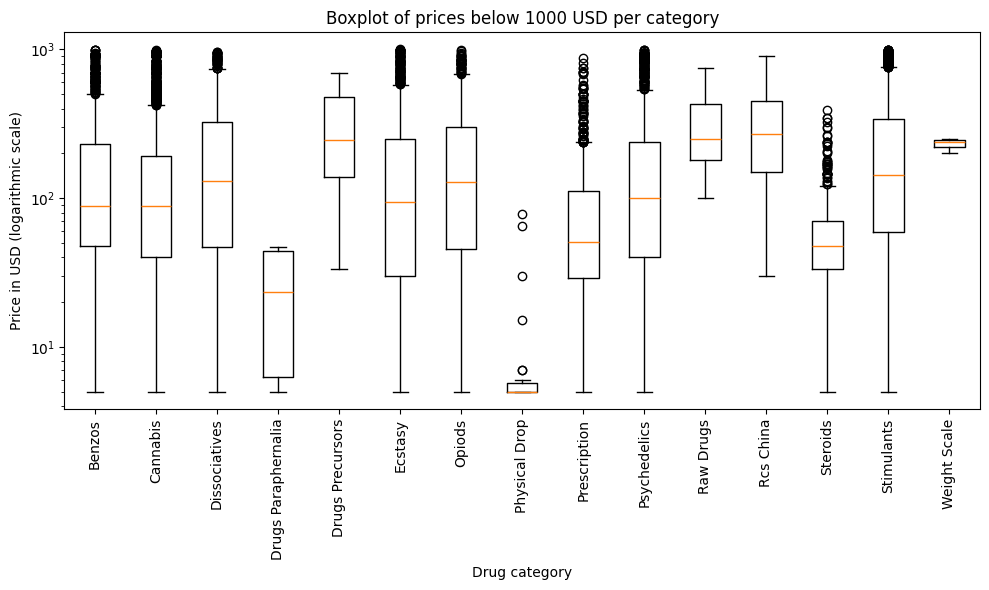

In [17]:
df_prices = df[['category', 'price']] \
    .where(df['price'] < 1000) \
    .groupby('category')['price'] \
    .apply(list) \
    .reset_index()

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.boxplot(df_prices['price'], labels=df_prices['category'])
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel("Drug category")
plt.ylabel("Price in USD (logarithmic scale)")
plt.yscale('log')
plt.title("Boxplot of prices below 1000 USD per category")
plt.tight_layout()
plt.show()

Visualise the amount of posts per drug.

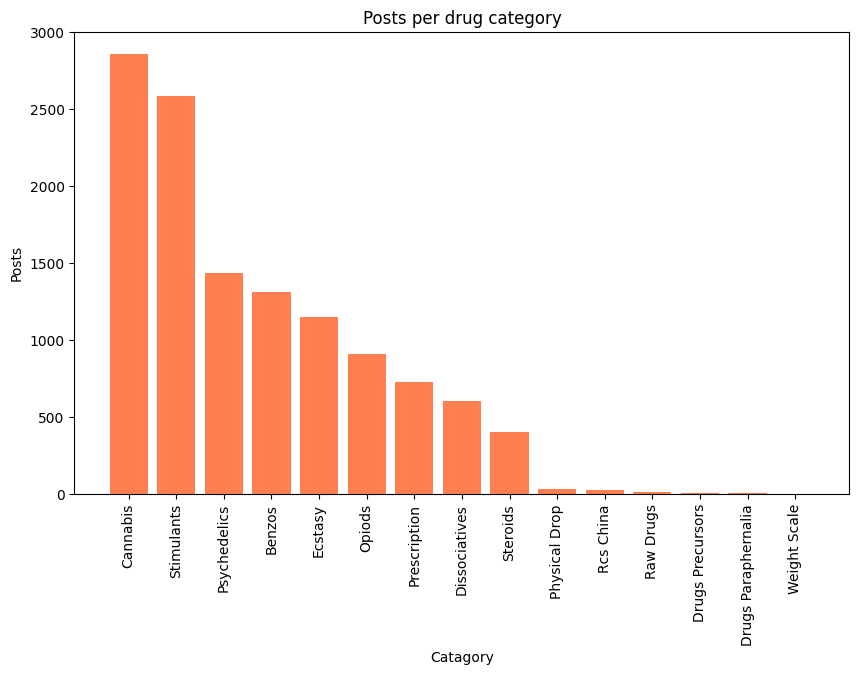

In [18]:
data_sorted = df_prices.copy()
data_sorted['price'] = data_sorted['price'].apply(len)
data_sorted = data_sorted \
    .rename(columns={'price':'count'}) \
    .sort_values(by='count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(data_sorted['category'], data_sorted['count'], color="coral")
plt.xlabel("Catagory")
plt.ylabel("Posts")
plt.xticks(rotation=90)
plt.title("Posts per drug category")
plt.show()


What surprised us the most in general is that the dark web is not only a place to purchase illegal goods but also for legal ones. This analysis was done on drugs, but the same marketplace also contains courses for finance. Forged clothes (2nd link) were also something we did not expect to have a marketplace, as we believed that this could also be sold on the clearnet. Lastly, it was interesting to see that alcohol still has a place on the black market.

- [lewis howes make 7 figures (2 masterclasses) 30gb](http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion/product/ELMPnqQjPCfeiEZixwLepxdBP5KKnlvi)
- [burberry hooded jacket](http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion/product/gGXwg9Wt0KBkMbAQ94AMvaEOlTptCKlY)
- [homebre alcohol 98% 189proof](http://2r7wa5og3ly4umqhmmqqytae6bufl5ql5kz7sorndpqtrkc2ri7tohad.onion/product/CTnLMQqnc0XSduJNtrd3UM11A2vu0yqa)

What was found, is that although cannabis has become legal in a lot of countries, it is still the biggest by number of postings. Out guess is that due to an easy manufacturing and lower risk with retrospect to hard drugs it is the easiest to export. Shortcomings were found in that on the posts there is no field for quantity. The quantity is usually in the description, but even here there is no exact format for quantity. For example a gram is referred to as 'gram', 'g', 'gr' among others. Because of this the analysis on price does not work. A price of 1000 is an outlier but maybe this is because of 10x as much volume for one posting. It was difficult to find a marketplace to scrape as most require a captcha which can not be bypassed by a bot.

In conclusion, this code provides a nice basis to further build on. Further research includes selecting a better marketplace for analysis. It would also be helpful to store the summarising statistics so an analysis can be done on how the marketplace develops over time.